In [80]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

### Combine 2016 donation data in Features folder

In [82]:
df_16 = pd.read_csv('./features/avgsum_donation-16.csv')

In [165]:
df_16=df_16[['CAND_ID','avgdonation','sumdonation']]
#df_16

In [166]:
df16bigdon = pd.read_csv('./features/num_big_donations-16.csv')
df16bigdon=df16bigdon[['CAND_ID','numdonat']]

#df16bigdon.head()

In [167]:
df16bigdon=df16bigdon.rename(columns={"numdonat": "num_big_donat"})

In [168]:
df16outofstatedon = pd.read_csv('./features/num_out_of_state_donations-16.csv')
df16outofstatedon=df16outofstatedon[['CAND_ID','numdonat']]
df16outofstatedon=df16outofstatedon.rename(columns={"numdonat": "num_OutOfState_donat"})
#df16outofstatedon.head()

In [169]:
#df_combined_2016 = df0.set_index('CAND_ID').join(df1.set_index('CAND_ID')).join(df2.set_index('CAND_ID'))
df_combined_2016 = df_16.merge(df16bigdon)
df_combined_2016 = df_combined_2016.merge(df16outofstatedon)
df_combined_2016

,CAND_ID,avgdonation,sumdonation,num_big_donat,num_OutOfState_donat
0,H6CA02234,2700.000000,2700.0,1,1
1,H0NH02181,305.662833,504955.0,294,806
2,S6NV00028,1750.742754,483205.0,232,179
3,H6IL06117,688.176871,606972.0,353,141
4,H8UT03089,1607.094488,204101.0,112,96
...,...,...,...,...,...
1076,H6NY03205,2226.666667,133600.0,56,6
1077,H8MN06047,1859.259259,150600.0,68,51
1078,H0PA03271,880.498258,252703.0,206,45
1079,H0WV02104,693.269231,54075.0,42,4


### Combine 2018 donation data in Features folder

In [89]:
df_18 = pd.read_csv('./features/avgsum_donation-18.csv')

In [171]:
df_18=df_18[['CAND_ID','avgdonation','sumdonation']]
#df_18

In [172]:
df18bigdon = pd.read_csv('./features/num_big_donations-18.csv')
df18bigdon=df18bigdon[['CAND_ID','numdonat']]

df18bigdon.head()
df18bigdon=df18bigdon.rename(columns={"numdonat": "num_big_donat"})
#df18bigdon

In [154]:
df18outofstatedon = pd.read_csv('./features/num_out_of_state_donations-18.csv')
df18outofstatedon=df18outofstatedon[['CAND_ID','numdonat']]
df18outofstatedon=df18outofstatedon.rename(columns={"numdonat": "num_OutOfState_donat"})
df18outofstatedon.head()

df_combined_2018 = df_18.merge(df18bigdon)
df_combined_2018 = df_combined_2018.merge(df18outofstatedon)
df_combined_2018

,CAND_ID,avgdonation,sumdonation,num_big_donat,num_OutOfState_donat
0,H0NH02181,396.934220,537052.0,330,498
1,H8TX06183,257.368557,299577.0,209,282
2,H8NJ07199,1767.674419,76010.0,34,12
3,S6NV00028,1723.076923,22400.0,10,4
4,H6IL06117,748.608848,2132038.0,1328,600
...,...,...,...,...,...
1309,H8MI11262,1126.526316,21404.0,11,1
1310,H0PA03271,770.102467,405844.0,345,100
1311,H8OK01173,396.313665,127613.0,113,7
1312,H8NY21245,334.981156,799935.0,539,215


### Combine 2016 and 2018 Donation Data

In [159]:
df_house_1618 = pd.concat([df_combined_2016,df_combined_2018])
df_house_1618

,CAND_ID,avgdonation,sumdonation,num_big_donat,num_OutOfState_donat
0,H6CA02234,2700.000000,2700.0,1,1
1,H0NH02181,305.662833,504955.0,294,806
2,S6NV00028,1750.742754,483205.0,232,179
3,H6IL06117,688.176871,606972.0,353,141
4,H8UT03089,1607.094488,204101.0,112,96
...,...,...,...,...,...
1309,H8MI11262,1126.526316,21404.0,11,1
1310,H0PA03271,770.102467,405844.0,345,100
1311,H8OK01173,396.313665,127613.0,113,7
1312,H8NY21245,334.981156,799935.0,539,215


In [94]:
############################# Previously done in Candidates.ipynb

### Functions:

In [95]:
def parse_file(file_name, file_header):
    '''Tool to load in an FEC file with associated header and produce a Spark Dataframe'''   

    #load data frame and split by delimiter  
    df_temp = sc.textFile(file_name).map(lambda row: [elem for elem in row.split('|')])
    
    #load separate header csv file and prepare schema 
    #assumes all values are STRING TYPE for simplicity
    head_temp = pd.read_csv(file_header)
    fields = [*[typ.StructField(h[:], typ.StringType(), True) for h in head_temp.columns]]
    schema = typ.StructType(fields)
    
    #finalize spark dataframe
    df = spark.createDataFrame(df_temp, schema)
    
    return df

### Read-in Population of Candidates from FEC Data:

In [96]:
df_candidate_20 = parse_file('./fec_data/cn/cn20.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_18 = parse_file('./fec_data/cn/cn18.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_16 = parse_file('./fec_data/cn/cn16.txt', './fec_data/cn/cn_header_file.csv')

dfs = [df_candidate_20, df_candidate_18, df_candidate_16]

#join all three data frames
df_candidate = reduce(DataFrame.unionAll, dfs)

###########################################
####### NEED TO Make PYSPARK ##############
###########################################

#converting to a pandas DF for ease of working with
df_candidate = df_candidate.select('*').toPandas() 

### Read-in Candidate election results from MIT Election Center Data:

In [97]:
#data from https://electionlab.mit.edu/data
df_MIT = pd.read_excel('1976-2018-house.xlsx')
df_filter18 = df_MIT[(df_MIT.year == 2018) & (df_MIT.writein == False)]
df_filter16 = df_MIT[(df_MIT.year == 2016) & (df_MIT.writein == False)]

---
### Join FEC and MIT Data based on one-time work above

**2016:**

In [98]:
#This is a version of the FEC data with columns added to join to the MIT Election Center Data
df_h16 = pd.read_excel('16tempfile.xlsx')

#filter for matches + need to remove any candidates without a CAND_PCC value. Candidates without this value do not have financial information available
df_h16 = df_h16[(df_h16.match == 1) & (df_h16.CAND_PCC.notna() == True)]
df_h16_final = df_h16.merge(df_filter16, left_on='match_id', right_index=True)

**2018:**

In [99]:
#This is a version of the FEC data with columns added to join to the MIT Election Center Data
df_h18 = pd.read_excel('18tempfile.xlsx')

#filter for matches + need to remove any candidates without a CAND_PCC value. candidates without this value do not have financial information available
df_h18 = df_h18[(df_h18.match == 1)&(df_h18.CAND_PCC.notna() == True)]
df_h18_final = df_h18.merge(df_filter18, left_on='match_id', right_index=True)

**Join 2016 and 2018:**

In [100]:
df_house = pd.concat([df_h16_final,df_h18_final])
df_house['VOTE_percent'] = df_house['candidatevotes']/df_house['totalvotes']

cols = ['CAND_ID',
        'CAND_NAME',
        'CAND_PTY_AFFILIATION',
        'CAND_ELECTION_YR',
        'CAND_OFFICE_ST',
        'CAND_OFFICE',
        'CAND_OFFICE_DISTRICT',
        'CAND_ICI',
        'CAND_STATUS',
        'CAND_PCC',
        'CAND_CITY',
        'CAND_ST',
        'CAND_ZIP',
        'candidatevotes',
        'totalvotes',
        'VOTE_percent']

df_house = df_house[cols]

#identify winners based on greater than 50% of votes
df_house['WINNER'] = np.where(df_house['VOTE_percent'] >= 0.5, 1, 0)

**Clean Joined Data Based on races with a Winner and races with sum vote totals <= 100%**

In [101]:
#identify elections we don't have a winner designated
#data is unfortunately not clean from source, some includes primary votes instead of final election results... 
#cleaning races without a winner based on given criteria and where vote % is >100% (some are over due to duplication or error?)

a_temp = df_house.groupby(['CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']).sum()
b_temp = a_temp[(a_temp.VOTE_percent > 1) | (a_temp.WINNER != 1)].reset_index()
c_temp = b_temp[['CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']]

#filter out races we don't have clean data 
keys = list(c_temp.columns.values)
i1 = df_house.set_index(keys).index
i2 = c_temp.set_index(keys).index
df_house = df_house[~i1.isin(i2)]

### Final '16 and '18 List of House of Representative Information

In [102]:
df_house=df_house[['CAND_ID','CAND_NAME','CAND_PTY_AFFILIATION','CAND_ELECTION_YR','CAND_OFFICE_ST','candidatevotes','totalvotes','VOTE_percent','WINNER']]


In [103]:
df_house

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,candidatevotes,totalvotes,VOTE_percent,WINNER
1,H6VA04061,"MCEACHIN, ASTON DONALD MR.",DEM,2016,VA,200136,346656,0.577333,1
2,H4NJ10085,"FRASER, AARON WALTER",DEM,2016,NJ,1746,222771,0.007838,0
3,H0CA27085,"SCHIFF, ADAM",DEM,2016,CA,210883,270409,0.779867,1
4,H0IL11052,"KINZINGER, ADAM",REP,2016,IL,259722,259853,0.999496,1
6,H6WA09025,"SMITH, D ADAM",DEM,2016,WA,205165,281482,0.728874,1
...,...,...,...,...,...,...,...,...,...
1062,H6AL04098,"ADERHOLT, ROBERT B. REP.",REP,2018,AL,184255,230969,0.797748,1
1064,H8AL02197,"ISNER, TABITHA KAY",DEM,2018,AL,86931,226230,0.384259,0
1065,H0AL02087,"ROBY, MARTHA",REP,2018,AL,138879,226230,0.613884,1
1066,H4AL01123,"BYRNE, BRADLEY ROBERTS",REP,2018,AL,153228,242617,0.631563,1


### Combine df_house data with the donations data

In [160]:
df_house = df_house.merge(df_house_1618)

In [161]:
df_house

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,candidatevotes,totalvotes,VOTE_percent,WINNER,avgdonation,sumdonation,num_big_donat,num_OutOfState_donat
0,H6VA04061,"MCEACHIN, ASTON DONALD MR.",DEM,2016,VA,200136,346656,0.577333,1,593.859599,207257.0,160,37
1,H6VA04061,"MCEACHIN, ASTON DONALD MR.",DEM,2016,VA,200136,346656,0.577333,1,360.413043,99474.0,69,26
2,H6VA04061,"MCEACHIN, ASTON DONALD",DEM,2018,VA,187642,299854,0.625778,1,593.859599,207257.0,160,37
3,H6VA04061,"MCEACHIN, ASTON DONALD",DEM,2018,VA,187642,299854,0.625778,1,360.413043,99474.0,69,26
4,H0CA27085,"SCHIFF, ADAM",DEM,2016,CA,210883,270409,0.779867,1,967.525000,193505.0,119,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,H8AL04094,"AUMAN, JAMES LEE",DEM,2018,AL,46492,230969,0.201291,0,283.670455,24963.0,25,29
2013,H8AL02197,"ISNER, TABITHA KAY",DEM,2018,AL,86931,226230,0.384259,0,375.796581,219841.0,159,327
2014,H0AL02087,"ROBY, MARTHA",REP,2018,AL,138879,226230,0.613884,1,1580.909091,86950.0,39,15
2015,H0AL02087,"ROBY, MARTHA",REP,2018,AL,138879,226230,0.613884,1,1258.790698,108256.0,52,19


### Create Corrlation Matrix

In [162]:
corrMatrix = df_house.corr()

In [163]:
corrMatrix

,CAND_ELECTION_YR,candidatevotes,totalvotes,VOTE_percent,WINNER,avgdonation,sumdonation,num_big_donat,num_OutOfState_donat
CAND_ELECTION_YR,1.000000,-0.272528,-0.299470,-0.082421,-0.099438,-0.047056,0.115313,0.131350,0.048677
candidatevotes,-0.272528,1.000000,0.491470,0.708619,0.647518,0.019573,0.061022,0.065861,0.067656
totalvotes,-0.299470,0.491470,1.000000,-0.224024,-0.069096,0.015062,0.126860,0.119831,0.057219
VOTE_percent,-0.082421,0.708619,-0.224024,1.000000,0.770450,0.017291,-0.029643,-0.020583,0.025140
WINNER,-0.099438,0.647518,-0.069096,0.770450,1.000000,0.019793,0.007734,0.032019,-0.003240
avgdonation,-0.047056,0.019573,0.015062,0.017291,0.019793,1.000000,0.226167,-0.043817,-0.066895
sumdonation,0.115313,0.061022,0.126860,-0.029643,0.007734,0.226167,1.000000,0.886132,0.458742
num_big_donat,0.131350,0.065861,0.119831,-0.020583,0.032019,-0.043817,0.886132,1.000000,0.483887
num_OutOfState_donat,0.048677,0.067656,0.057219,0.025140,-0.003240,-0.066895,0.458742,0.483887,1.000000


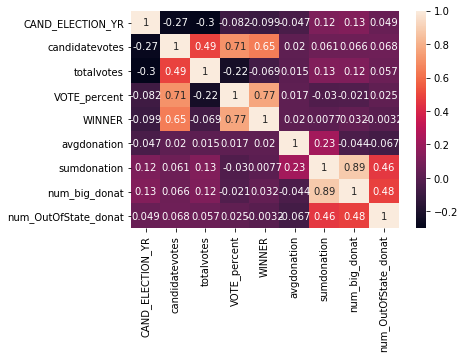

In [164]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

### From the Correlation Matrix above, Winner is highly correlated to the candidatevotes and VOTE_percent variables with 0.65 and 0.77 correlation. Among donation variables, average donation and number of big donations have the most correlation on the Winners with 0.02 and 0.032 correlation. 